## 1. Configuración e Instalación de Dependencias

In [1]:
# Instalar Prophet si no está instalado
# !pip install prophet matplotlib seaborn plotly

In [2]:
# Importar librerías
import warnings
warnings.filterwarnings('ignore')

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Pandas y Prophet
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

# Configurar estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar Datos con PySpark

In [3]:
# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Olist Demand Forecasting") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .getOrCreate()

print(f"✓ Sesión Spark creada: {spark.version}")

✓ Sesión Spark creada: 3.5.0


In [4]:
# Cargar dataset unificado
df_spark = spark.read.parquet("Data/olist_unified_dataset.parquet")

print(f"Registros totales: {df_spark.count():,}")
print(f"Columnas: {len(df_spark.columns)}")

Registros totales: 112,650
Columnas: 52


## 3. Preparación de Datos para Series de Tiempo (PySpark)

In [5]:
print("=" * 70)
print("PREPARACIÓN DE DATOS PARA SERIES DE TIEMPO")
print("=" * 70)

# Seleccionar columnas relevantes y filtrar datos válidos
df_ts = df_spark.select(
    F.col('order_purchase_timestamp').alias('fecha'),
    F.col('payment_value').alias('ventas')
).filter(
    (F.col('order_purchase_timestamp').isNotNull()) & 
    (F.col('payment_value').isNotNull()) &
    (F.col('payment_value') > 0)
)

# Ver rango de fechas
date_range = df_ts.agg(
    F.min('fecha').alias('fecha_min'),
    F.max('fecha').alias('fecha_max'),
    F.count('*').alias('total_registros')
).collect()[0]

print(f"\nRango de fechas: {date_range['fecha_min']} a {date_range['fecha_max']}")
print(f"Total de registros válidos: {date_range['total_registros']:,}")

# Calcular diferencia en días
days_diff = (date_range['fecha_max'] - date_range['fecha_min']).days
print(f"Días de datos: {days_diff} (~{days_diff/365:.1f} años)")

PREPARACIÓN DE DATOS PARA SERIES DE TIEMPO

Rango de fechas: 2016-09-04 21:15:19 a 2018-09-03 09:06:57
Total de registros válidos: 112,647
Días de datos: 728 (~2.0 años)


In [6]:
# Agregar ventas por SEMANA (recomendado para Prophet)
# Usamos la función date_trunc para agrupar por semana
df_weekly = df_ts.withColumn(
    'semana',
    F.date_trunc('week', 'fecha')
).groupBy('semana') \
 .agg(
     F.sum('ventas').alias('ventas_total'),
     F.count('*').alias('num_ordenes'),
     F.avg('ventas').alias('ventas_promedio')
 ) \
 .orderBy('semana')

print("\nVentas agregadas por semana:")
df_weekly.show(10)

print(f"\nTotal de semanas: {df_weekly.count()}")


Ventas agregadas por semana:
+-------------------+-----------------+-----------+------------------+
|             semana|     ventas_total|num_ordenes|   ventas_promedio|
+-------------------+-----------------+-----------+------------------+
|2016-08-29 00:00:00|           272.46|          2|            136.23|
|2016-09-05 00:00:00|            75.06|          1|             75.06|
|2016-09-26 00:00:00|           109.34|          1|            109.34|
|2016-10-03 00:00:00|68898.59000000008|        322|213.97077639751578|
|2016-10-10 00:00:00|4906.650000000001|         40|122.66625000000002|
|2016-12-19 00:00:00|            19.62|          1|             19.62|
|2017-01-02 00:00:00|4799.689999999998|         47|102.12106382978719|
|2017-01-09 00:00:00|         16617.14|         89|186.70943820224718|
|2017-01-16 00:00:00|40624.16000000001|        239|169.97556485355653|
|2017-01-23 00:00:00|82436.67000000003|        420|196.27778571428578|
+-------------------+-----------------+--------

## 4. Convertir a Pandas para Prophet

In [7]:
# Convertir a Pandas DataFrame
df_pd = df_weekly.select('semana', 'ventas_total').toPandas()

# Renombrar columnas al formato requerido por Prophet: 'ds' (fecha) y 'y' (valor)
df_pd.columns = ['ds', 'y']

# Asegurar que 'ds' sea datetime
df_pd['ds'] = pd.to_datetime(df_pd['ds'])

# Ordenar por fecha
df_pd = df_pd.sort_values('ds').reset_index(drop=True)

print("Dataset convertido a Pandas para Prophet:")
print(f"Shape: {df_pd.shape}")
print(f"\nPrimeras filas:")
display(df_pd.head(10))

print(f"\nÚltimas filas:")
display(df_pd.tail(10))

# Estadísticas básicas
print(f"\nEstadísticas de ventas semanales:")
print(df_pd['y'].describe())

Dataset convertido a Pandas para Prophet:
Shape: (94, 2)

Primeras filas:


,ds,y
0,2016-08-29,272.46
1,2016-09-05,75.06
2,2016-09-26,109.34
3,2016-10-03,68898.59
4,2016-10-10,4906.65
5,2016-12-19,19.62
6,2017-01-02,4799.69
7,2017-01-09,16617.14
8,2017-01-16,40624.16
9,2017-01-23,82436.67



Últimas filas:


,ds,y
84,2018-07-02,250384.53
85,2018-07-09,245588.80
86,2018-07-16,325757.60
87,2018-07-23,364694.14
88,2018-07-30,396803.00
89,2018-08-06,439154.03
90,2018-08-13,332085.63
91,2018-08-20,171726.50
92,2018-08-27,15996.14
93,2018-09-03,166.46



Estadísticas de ventas semanales:
count        94.000000
mean     216043.986277
std      125408.745423
min          19.620000
25%      130344.825000
50%      212390.830000
75%      314149.587500
max      658518.600000
Name: y, dtype: float64


## 5. Análisis Exploratorio de la Serie de Tiempo

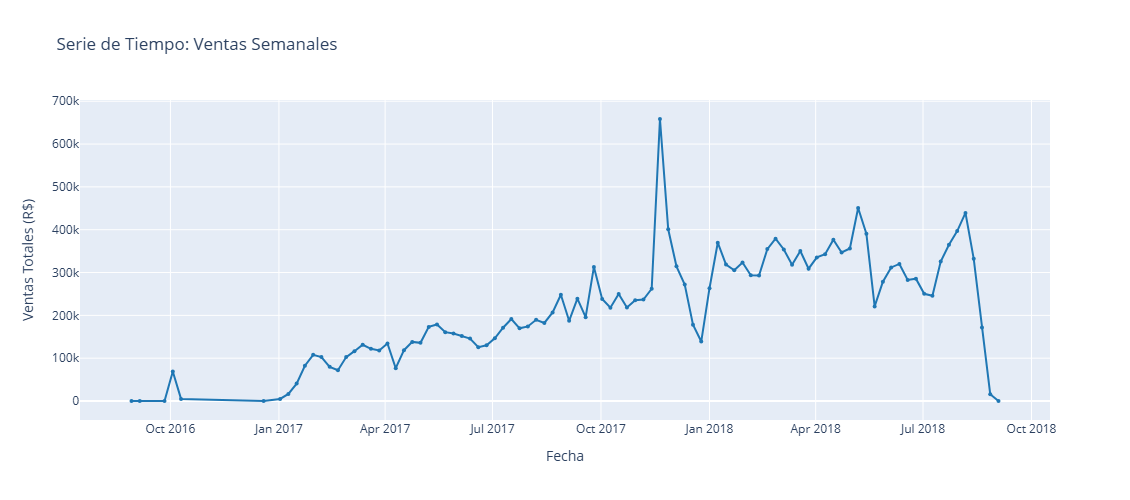

✓ Gráfico de serie de tiempo generado


In [8]:
# Visualización de la serie de tiempo
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_pd['ds'],
    y=df_pd['y'],
    mode='lines+markers',
    name='Ventas Semanales',
    line=dict(color='#1f77b4', width=2),
    marker=dict(size=4)
))

fig.update_layout(
    title='Serie de Tiempo: Ventas Semanales',
    xaxis_title='Fecha',
    yaxis_title='Ventas Totales (R$)',
    height=500,
    hovermode='x unified'
)

fig.show()

print("✓ Gráfico de serie de tiempo generado")

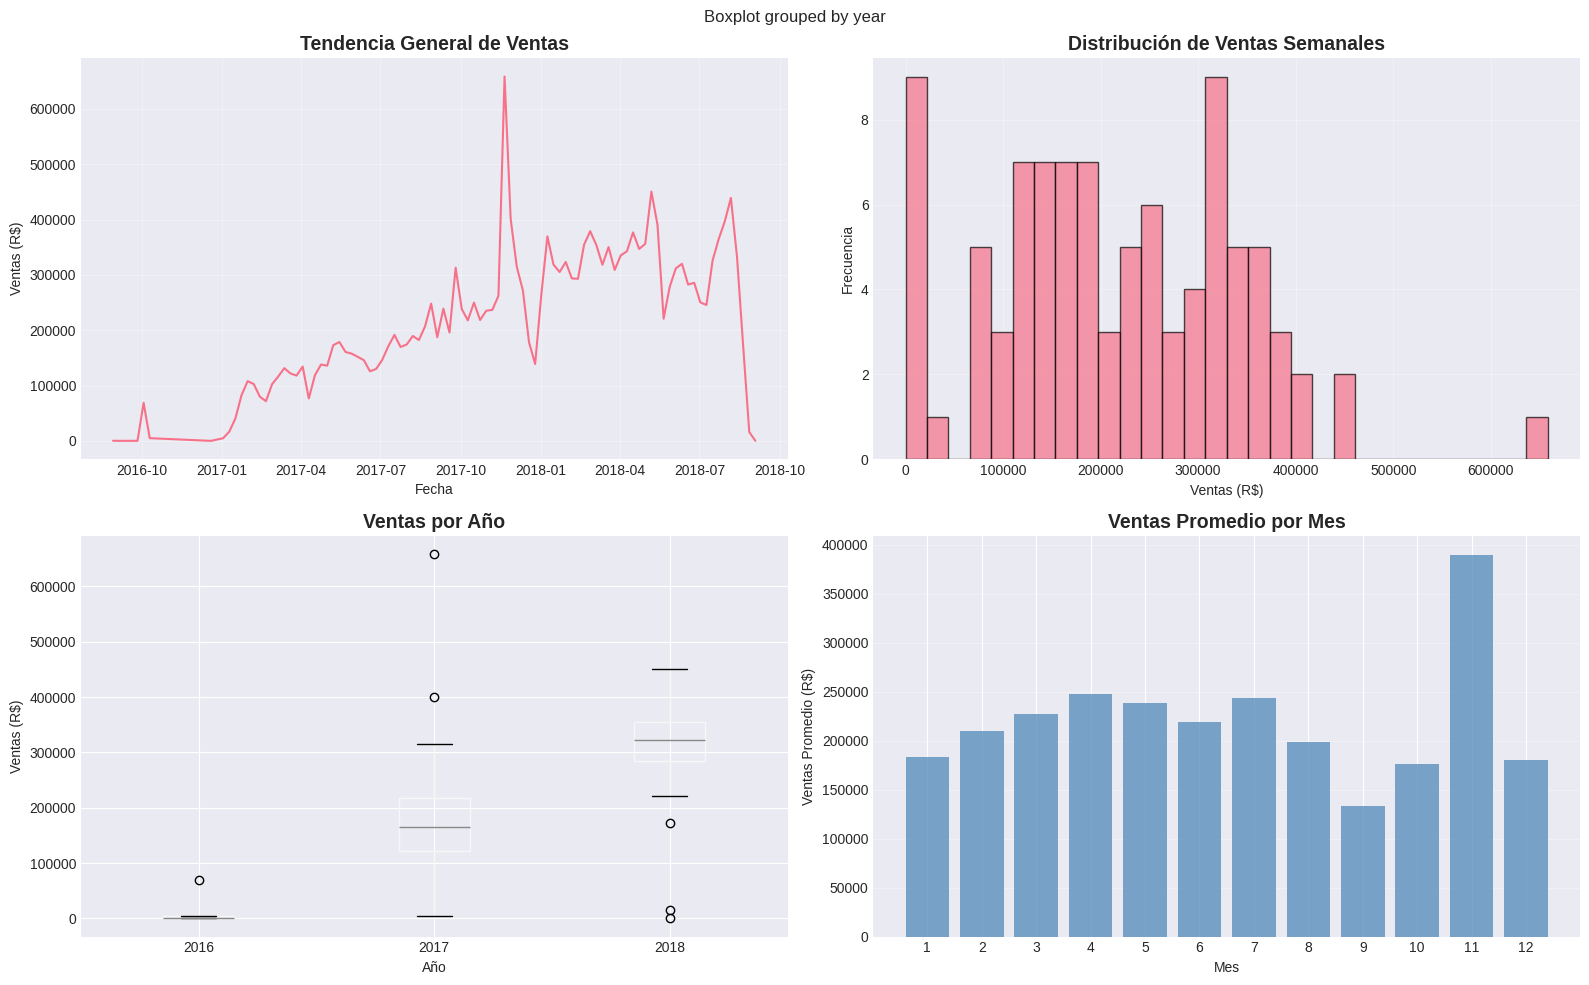

✓ Análisis exploratorio completado


In [9]:
# Análisis de tendencia y estacionalidad visual
df_pd['year'] = df_pd['ds'].dt.year
df_pd['month'] = df_pd['ds'].dt.month
df_pd['week'] = df_pd['ds'].dt.isocalendar().week

# Ventas por mes
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Tendencia general
axes[0, 0].plot(df_pd['ds'], df_pd['y'], linewidth=1.5)
axes[0, 0].set_title('Tendencia General de Ventas', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Ventas (R$)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribución de ventas
axes[0, 1].hist(df_pd['y'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución de Ventas Semanales', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Ventas (R$)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# 3. Boxplot por año
df_pd.boxplot(column='y', by='year', ax=axes[1, 0])
axes[1, 0].set_title('Ventas por Año', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Año')
axes[1, 0].set_ylabel('Ventas (R$)')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 4. Ventas promedio por mes
monthly_avg = df_pd.groupby('month')['y'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='steelblue', alpha=0.7)
axes[1, 1].set_title('Ventas Promedio por Mes', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Mes')
axes[1, 1].set_ylabel('Ventas Promedio (R$)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Análisis exploratorio completado")

In [10]:
# Análisis de estacionalidad - promedio por mes del año
print("\nVentas promedio por mes (agregado de todos los años):")
monthly_sales = df_pd.groupby('month')['y'].agg(['mean', 'std', 'count'])
monthly_sales.index = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                       'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
display(monthly_sales)


Ventas promedio por mes (agregado de todos los años):


,mean,std,count
Ene,183260.402000,145215.927690,10
Feb,209649.403750,132269.118976,8
Mar,227390.060000,113820.880174,8
Abr,247271.878889,125379.429588,9
May,238507.347778,112335.052653,9
Jun,219217.777500,87666.885998,8
Jul,243613.906000,89836.621556,10
Ago,198461.692222,137820.610174,9
Sep,133660.102857,131364.154998,7
Oct,176239.092857,97606.472952,7


## 6. División de Datos: Train/Test

In [11]:
# Dividir en train/test
# Reservar últimas 13 semanas (~3 meses) para test
test_weeks = 13
train_size = len(df_pd) - test_weeks

df_train = df_pd.iloc[:train_size].copy()
df_test = df_pd.iloc[train_size:].copy()

print("=" * 70)
print("DIVISIÓN TRAIN/TEST")
print("=" * 70)
print(f"\nTotal de datos: {len(df_pd)} semanas")
print(f"Train: {len(df_train)} semanas ({df_train['ds'].min()} a {df_train['ds'].max()})")
print(f"Test: {len(df_test)} semanas ({df_test['ds'].min()} a {df_test['ds'].max()})")
print(f"\nPorcentaje train: {len(df_train)/len(df_pd)*100:.1f}%")
print(f"Porcentaje test: {len(df_test)/len(df_pd)*100:.1f}%")

DIVISIÓN TRAIN/TEST

Total de datos: 94 semanas
Train: 81 semanas (2016-08-29 00:00:00 a 2018-06-04 00:00:00)
Test: 13 semanas (2018-06-11 00:00:00 a 2018-09-03 00:00:00)

Porcentaje train: 86.2%
Porcentaje test: 13.8%


## 7. Entrenamiento del Modelo Prophet

In [12]:
print("=" * 70)
print("ENTRENAMIENTO DEL MODELO PROPHET")
print("=" * 70)

# Crear modelo Prophet con configuración optimizada para e-commerce
model = Prophet(
    seasonality_mode='multiplicative',  # Mejor para series con estacionalidad proporcional
    yearly_seasonality=True,            # Capturar patrones anuales
    weekly_seasonality=True,            # Capturar patrones semanales
    daily_seasonality=False,            # No necesario para datos semanales
    changepoint_prior_scale=0.05,       # Flexibilidad moderada para cambios de tendencia
    seasonality_prior_scale=10,         # Peso para estacionalidad
    interval_width=0.95,                # Intervalos de confianza al 95%
    n_changepoints=25                   # Número de puntos de cambio potenciales
)

# Agregar holidays brasileños (importantes para e-commerce)
model.add_country_holidays(country_name='BR')

print("\n✓ Modelo Prophet configurado")
print("\nConfiguraciones clave:")
print("  - Estacionalidad: multiplicativa")
print("  - Estacionalidad anual: activada")
print("  - Estacionalidad semanal: activada")
print("  - Holidays de Brasil: incluidos")
print("  - Intervalo de confianza: 95%")

# Entrenar el modelo
print("\nEntrenando modelo...")
model.fit(df_train)
print("✓ Modelo entrenado exitosamente")

ENTRENAMIENTO DEL MODELO PROPHET


06:42:48 - cmdstanpy - INFO - Chain [1] start processing



✓ Modelo Prophet configurado

Configuraciones clave:
  - Estacionalidad: multiplicativa
  - Estacionalidad anual: activada
  - Estacionalidad semanal: activada
  - Holidays de Brasil: incluidos
  - Intervalo de confianza: 95%

Entrenando modelo...


06:42:48 - cmdstanpy - INFO - Chain [1] done processing


✓ Modelo entrenado exitosamente


## 8. Predicción en Test Set

In [13]:
# Hacer predicciones en el conjunto de test
forecast_test = model.predict(df_test[['ds']])

# Comparar predicciones con valores reales
df_comparison = pd.DataFrame({
    'fecha': df_test['ds'].values,
    'real': df_test['y'].values,
    'prediccion': forecast_test['yhat'].values,
    'limite_inferior': forecast_test['yhat_lower'].values,
    'limite_superior': forecast_test['yhat_upper'].values
})

print("\nComparación de predicciones vs valores reales (Test Set):")
display(df_comparison)

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_comparison['real'], df_comparison['prediccion'])
rmse = np.sqrt(mean_squared_error(df_comparison['real'], df_comparison['prediccion']))
mape = np.mean(np.abs((df_comparison['real'] - df_comparison['prediccion']) / df_comparison['real'])) * 100
r2 = r2_score(df_comparison['real'], df_comparison['prediccion'])

print("\n" + "=" * 70)
print("MÉTRICAS DE EVALUACIÓN EN TEST SET")
print("=" * 70)
print(f"MAE (Error Absoluto Medio): R$ {mae:,.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): R$ {rmse:,.2f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.2f}%")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")
print("\nInterpretación:")
print(f"  - En promedio, las predicciones se desvían R$ {mae:,.2f} del valor real")
print(f"  - El error porcentual promedio es {mape:.1f}%")
print(f"  - El modelo explica {r2*100:.1f}% de la varianza de los datos")


Comparación de predicciones vs valores reales (Test Set):


,fecha,real,prediccion,limite_inferior,limite_superior
0,2018-06-11,320071.04,329652.935622,254015.548457,409908.781375
1,2018-06-18,282589.37,345569.989970,272230.314745,424509.566061
2,2018-06-25,285656.11,337677.622284,259908.723224,411939.829960
3,2018-07-02,250384.53,328555.193364,251044.162402,401224.520971
4,2018-07-09,245588.80,343549.150779,265283.419878,416019.243597
5,2018-07-16,325757.60,379398.118139,296909.172888,450544.551377
6,2018-07-23,364694.14,406803.893390,332939.379956,478785.913263
7,2018-07-30,396803.00,404638.269251,331323.663421,473424.341520
8,2018-08-06,439154.03,385974.289656,317234.996652,462950.338693
9,2018-08-13,332085.63,384323.090188,309984.702763,462712.347887



MÉTRICAS DE EVALUACIÓN EN TEST SET
MAE (Error Absoluto Medio): R$ 127,721.39
RMSE (Raíz del Error Cuadrático Medio): R$ 196,947.52
MAPE (Error Porcentual Absoluto Medio): 21925.75%
R² (Coeficiente de Determinación): -1.3896

Interpretación:
  - En promedio, las predicciones se desvían R$ 127,721.39 del valor real
  - El error porcentual promedio es 21925.7%
  - El modelo explica -139.0% de la varianza de los datos


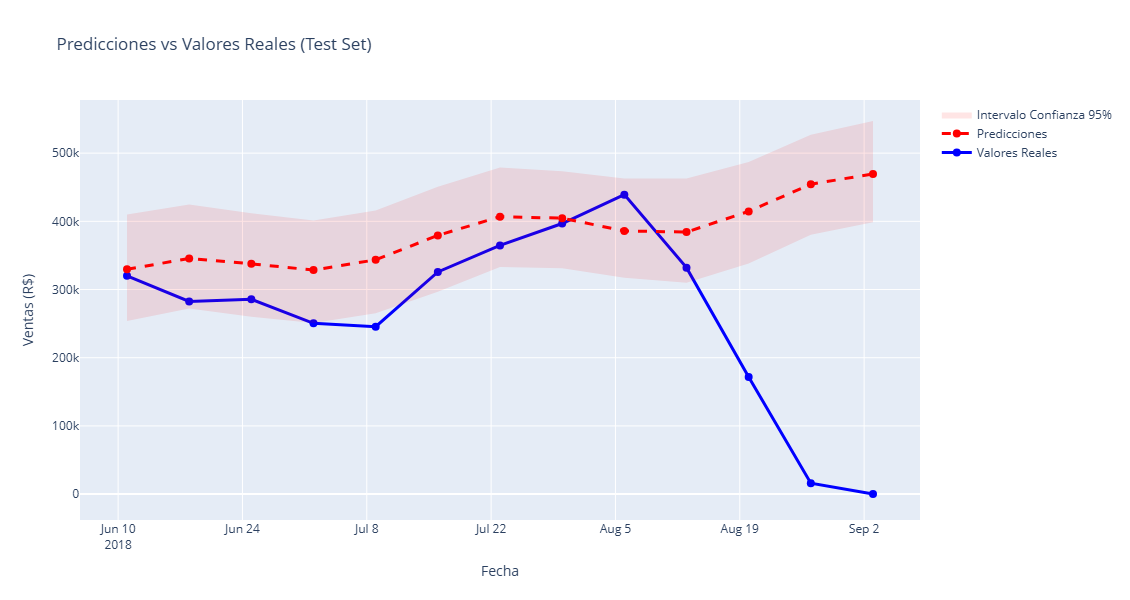

In [14]:
# Visualización de predicciones vs reales en test set
fig = go.Figure()

# Valores reales
fig.add_trace(go.Scatter(
    x=df_comparison['fecha'],
    y=df_comparison['real'],
    mode='lines+markers',
    name='Valores Reales',
    line=dict(color='blue', width=3),
    marker=dict(size=8)
))

# Predicciones
fig.add_trace(go.Scatter(
    x=df_comparison['fecha'],
    y=df_comparison['prediccion'],
    mode='lines+markers',
    name='Predicciones',
    line=dict(color='red', width=3, dash='dash'),
    marker=dict(size=8)
))

# Intervalo de confianza
fig.add_trace(go.Scatter(
    x=df_comparison['fecha'],
    y=df_comparison['limite_superior'],
    mode='lines',
    name='IC 95% Superior',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df_comparison['fecha'],
    y=df_comparison['limite_inferior'],
    mode='lines',
    name='Intervalo Confianza 95%',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.1)',
    line=dict(width=0)
))

fig.update_layout(
    title='Predicciones vs Valores Reales (Test Set)',
    xaxis_title='Fecha',
    yaxis_title='Ventas (R$)',
    height=600,
    hovermode='x unified'
)

fig.show()

## 9. Predicción para el Próximo Trimestre (13 semanas)

In [15]:
print("=" * 70)
print("PREDICCIÓN PARA EL PRÓXIMO TRIMESTRE")
print("=" * 70)

# Reentrenar el modelo con TODOS los datos disponibles
print("\nReentrenando modelo con todos los datos...")
model_full = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    interval_width=0.95,
    n_changepoints=25
)

model_full.add_country_holidays(country_name='BR')
model_full.fit(df_pd)
print("✓ Modelo reentrenado con dataset completo")

# Crear dataframe futuro para 13 semanas (1 trimestre)
future_weeks = 13
future = model_full.make_future_dataframe(periods=future_weeks, freq='W')

# Hacer predicción
forecast = model_full.predict(future)

# Extraer solo las predicciones futuras
forecast_future = forecast.iloc[-future_weeks:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_future.columns = ['Fecha', 'Predicción', 'Límite Inferior (95%)', 'Límite Superior (95%)']

print(f"\nPredicciones para las próximas {future_weeks} semanas:")
print(f"Desde: {forecast_future['Fecha'].min()}")
print(f"Hasta: {forecast_future['Fecha'].max()}")
print("\n")
display(forecast_future)

# Calcular totales del trimestre
total_predicho = forecast_future['Predicción'].sum()
total_inferior = forecast_future['Límite Inferior (95%)'].sum()
total_superior = forecast_future['Límite Superior (95%)'].sum()

print("\n" + "=" * 70)
print("PRONÓSTICO TRIMESTRAL TOTAL")
print("=" * 70)
print(f"Ventas esperadas (próximo trimestre): R$ {total_predicho:,.2f}")
print(f"Escenario pesimista (límite inferior): R$ {total_inferior:,.2f}")
print(f"Escenario optimista (límite superior): R$ {total_superior:,.2f}")
print(f"\nRango de variación: R$ {total_superior - total_inferior:,.2f}")

# Comparar con trimestre anterior
last_13_weeks_actual = df_pd.iloc[-13:]['y'].sum()
growth_pct = ((total_predicho - last_13_weeks_actual) / last_13_weeks_actual) * 100

print(f"\nVentas del último trimestre real: R$ {last_13_weeks_actual:,.2f}")
print(f"Crecimiento esperado: {growth_pct:+.2f}%")

06:43:01 - cmdstanpy - INFO - Chain [1] start processing


PREDICCIÓN PARA EL PRÓXIMO TRIMESTRE

Reentrenando modelo con todos los datos...


06:43:02 - cmdstanpy - INFO - Chain [1] done processing


✓ Modelo reentrenado con dataset completo

Predicciones para las próximas 13 semanas:
Desde: 2018-09-09 00:00:00
Hasta: 2018-12-02 00:00:00




,Fecha,Predicción,Límite Inferior (95%),Límite Superior (95%)
94,2018-09-09,333473.496401,242135.632037,4.349650e+05
95,2018-09-16,494571.827768,397505.410677,5.879175e+05
96,2018-09-23,615108.297067,514944.292351,7.160253e+05
97,2018-09-30,649464.391925,553764.883075,7.486294e+05
98,2018-10-07,609321.666887,512054.971941,7.103186e+05
99,2018-10-14,537795.419131,440672.502093,6.415164e+05
100,2018-10-21,481554.500176,380830.415723,5.758087e+05
101,2018-10-28,482945.665823,379428.153827,5.787725e+05
102,2018-11-04,572339.612453,477813.453570,6.682186e+05
103,2018-11-11,739725.882389,645904.459855,8.385573e+05



PRONÓSTICO TRIMESTRAL TOTAL
Ventas esperadas (próximo trimestre): R$ 8,252,523.54
Escenario pesimista (límite inferior): R$ 6,987,354.55
Escenario optimista (límite superior): R$ 9,531,681.49

Rango de variación: R$ 2,544,326.94

Ventas del último trimestre real: R$ 3,430,673.35
Crecimiento esperado: +140.55%


## 10. Visualizaciones del Pronóstico

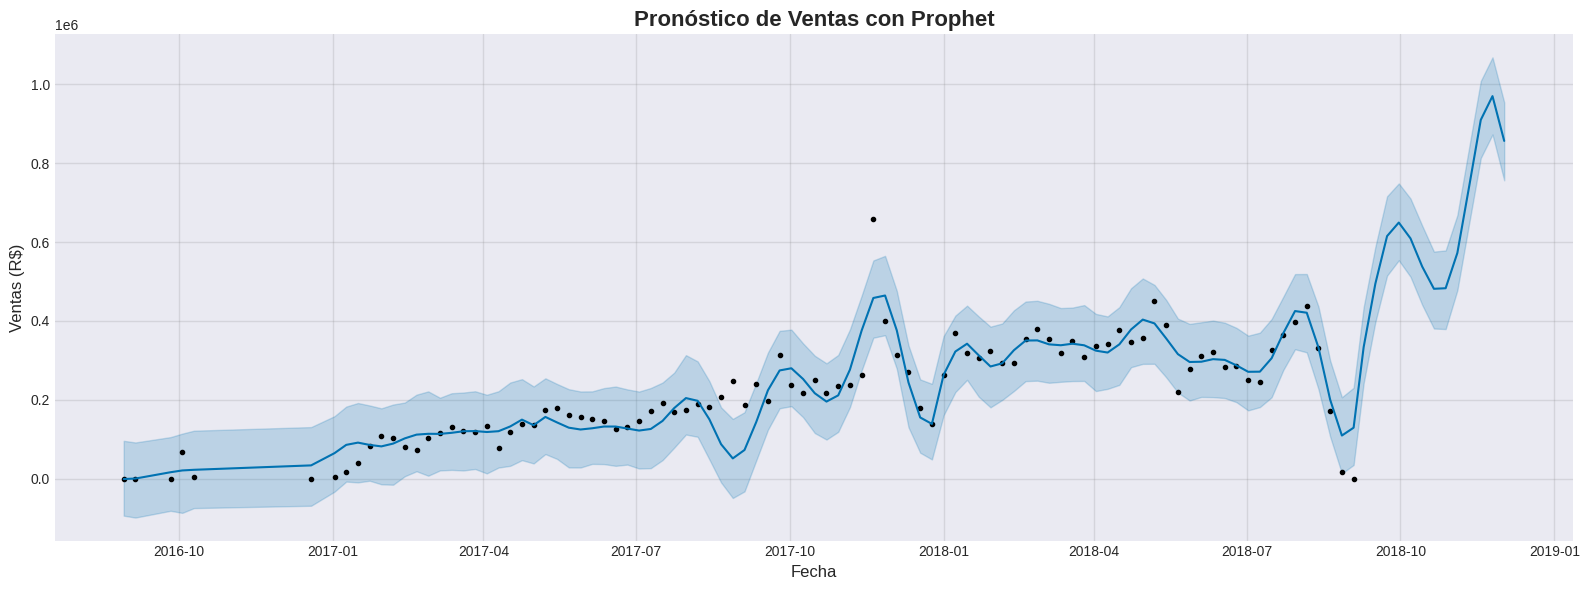

✓ Gráfico de pronóstico generado


In [16]:
# Gráfico completo de pronóstico con Prophet
fig1 = model_full.plot(forecast, figsize=(16, 6))
plt.title('Pronóstico de Ventas con Prophet', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas (R$)', fontsize=12)
plt.tight_layout()
plt.show()

print("✓ Gráfico de pronóstico generado")

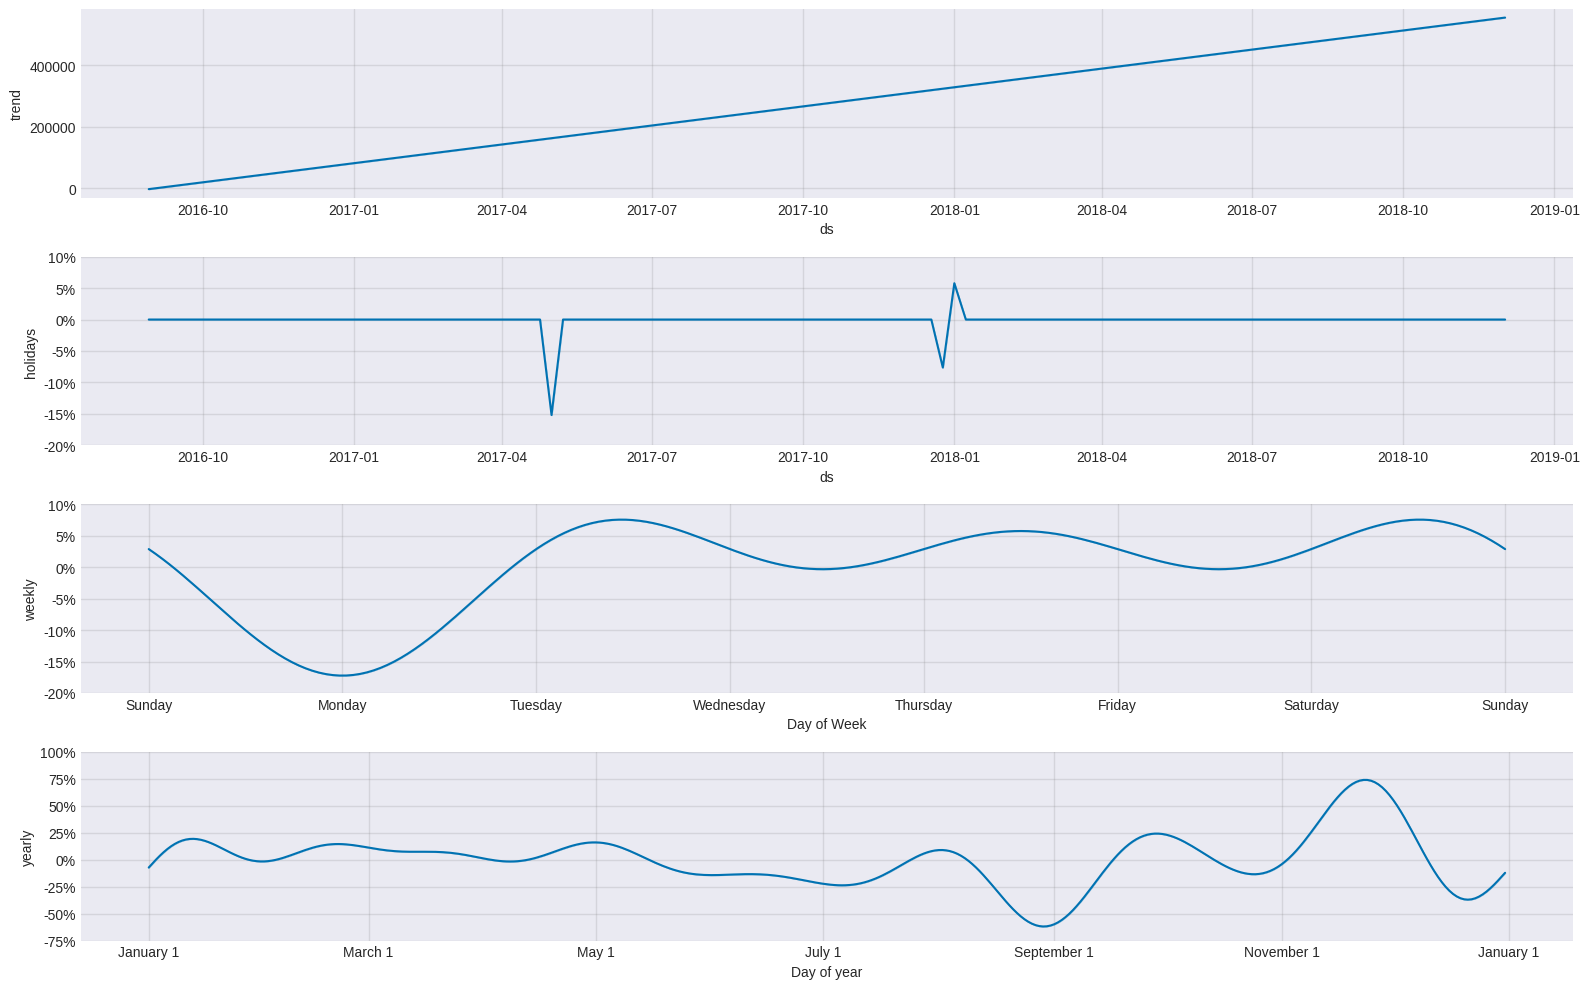

✓ Componentes del modelo visualizados

Interpretación de componentes:
  1. Trend: Tendencia general de ventas a lo largo del tiempo
  2. Weekly: Patrón semanal (días con más/menos ventas)
  3. Yearly: Estacionalidad anual (meses con más/menos ventas)
  4. Holidays: Impacto de días festivos brasileños en las ventas


In [17]:
# Componentes del modelo (tendencia, estacionalidad)
fig2 = model_full.plot_components(forecast, figsize=(16, 10))
plt.tight_layout()
plt.show()

print("✓ Componentes del modelo visualizados")
print("\nInterpretación de componentes:")
print("  1. Trend: Tendencia general de ventas a lo largo del tiempo")
print("  2. Weekly: Patrón semanal (días con más/menos ventas)")
print("  3. Yearly: Estacionalidad anual (meses con más/menos ventas)")
print("  4. Holidays: Impacto de días festivos brasileños en las ventas")

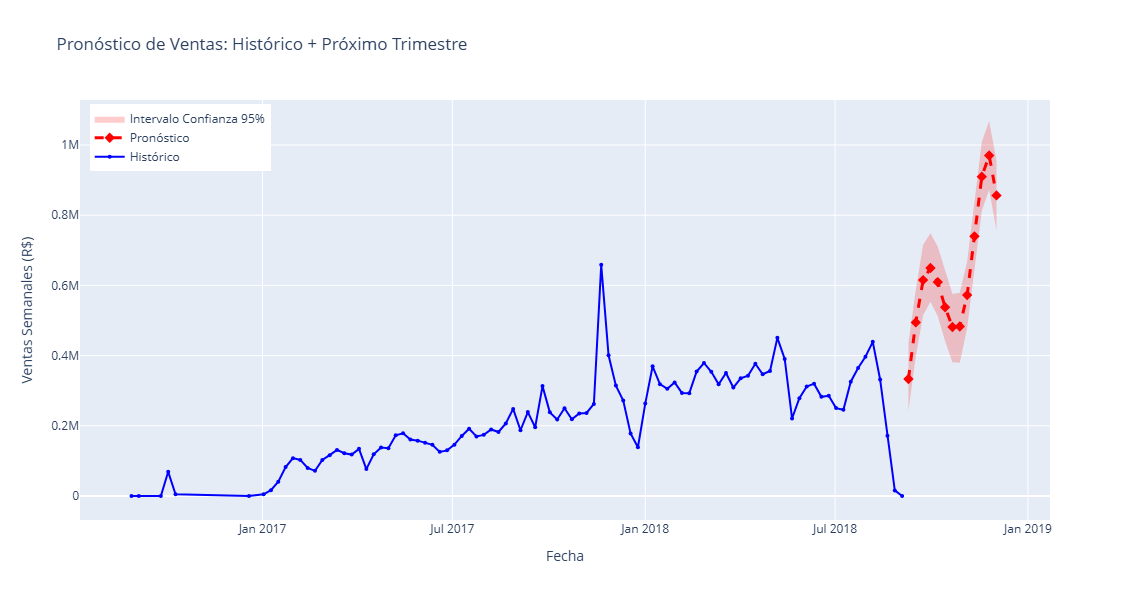

In [18]:
# Visualización interactiva con Plotly - Histórico + Pronóstico
fig = go.Figure()

# Datos históricos
fig.add_trace(go.Scatter(
    x=df_pd['ds'],
    y=df_pd['y'],
    mode='lines+markers',
    name='Histórico',
    line=dict(color='blue', width=2),
    marker=dict(size=4)
))

# Pronóstico futuro
fig.add_trace(go.Scatter(
    x=forecast_future['Fecha'],
    y=forecast_future['Predicción'],
    mode='lines+markers',
    name='Pronóstico',
    line=dict(color='red', width=3, dash='dash'),
    marker=dict(size=8, symbol='diamond')
))

# Intervalo de confianza
fig.add_trace(go.Scatter(
    x=forecast_future['Fecha'],
    y=forecast_future['Límite Superior (95%)'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=forecast_future['Fecha'],
    y=forecast_future['Límite Inferior (95%)'],
    mode='lines',
    name='Intervalo Confianza 95%',
    fill='tonexty',
    fillcolor='rgba(255, 0, 0, 0.2)',
    line=dict(width=0)
))

fig.update_layout(
    title='Pronóstico de Ventas: Histórico + Próximo Trimestre',
    xaxis_title='Fecha',
    yaxis_title='Ventas Semanales (R$)',
    height=600,
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()

## 11. Análisis de Cambios de Tendencia (Changepoints)

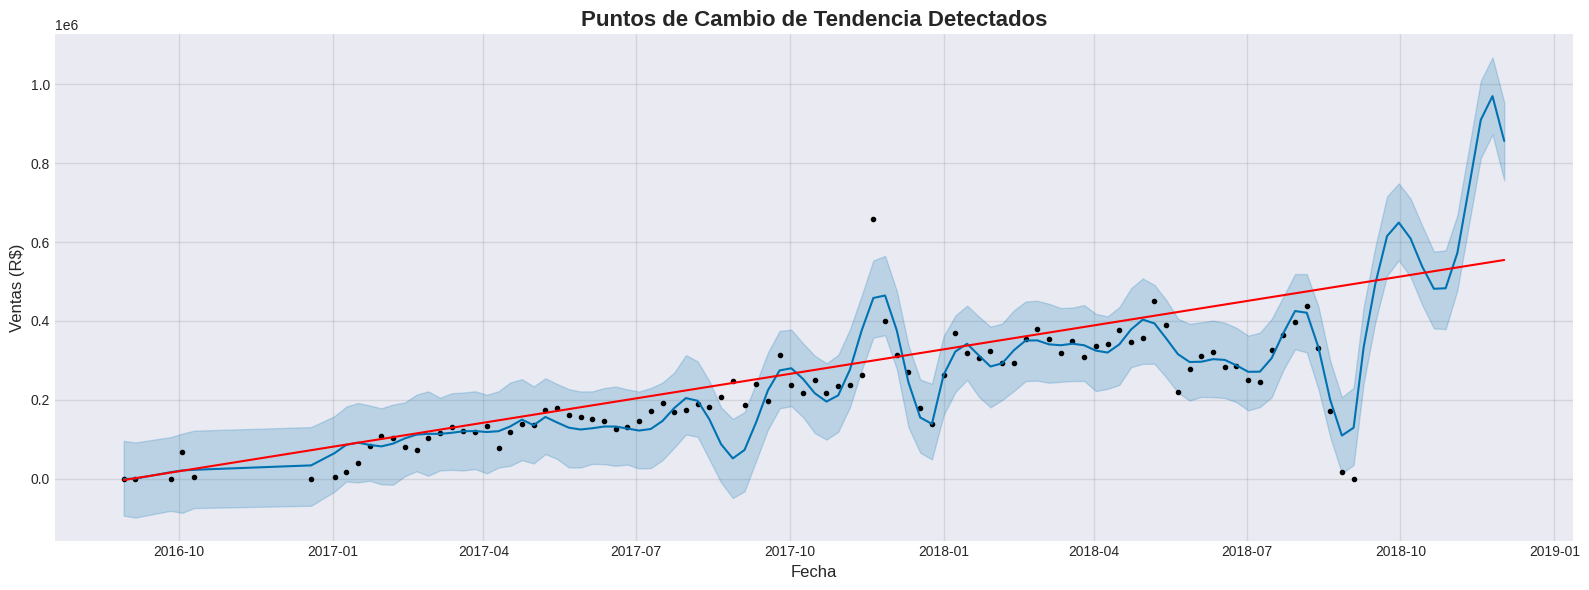


✓ Puntos de cambio visualizados

Las líneas verticales rojas indican momentos donde el modelo detectó
cambios significativos en la tendencia de ventas.


In [19]:
# Visualizar puntos de cambio detectados por Prophet
from prophet.plot import add_changepoints_to_plot

fig = model_full.plot(forecast, figsize=(16, 6))
a = add_changepoints_to_plot(fig.gca(), model_full, forecast)
plt.title('Puntos de Cambio de Tendencia Detectados', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas (R$)', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Puntos de cambio visualizados")
print("\nLas líneas verticales rojas indican momentos donde el modelo detectó")
print("cambios significativos en la tendencia de ventas.")

## 12. Validación Cruzada (Cross-Validation)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Realizando validación cruzada (esto puede tomar unos minutos)...


  0%|          | 0/4 [00:00<?, ?it/s]

06:43:19 - cmdstanpy - INFO - Chain [1] start processing
06:43:20 - cmdstanpy - INFO - Chain [1] done processing
06:43:20 - cmdstanpy - INFO - Chain [1] start processing
06:43:20 - cmdstanpy - INFO - Chain [1] done processing
06:43:20 - cmdstanpy - INFO - Chain [1] start processing
06:43:22 - cmdstanpy - INFO - Chain [1] done processing
06:43:22 - cmdstanpy - INFO - Chain [1] start processing
06:43:23 - cmdstanpy - INFO - Chain [1] done processing


✓ Validación cruzada completada

Métricas de validación cruzada:


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,7.033492e+09,83865.917107,73256.854441,0.301635,0.314455,0.364635,0.4
1,11 days,1.243550e+11,352639.974492,209154.229590,1.090445,0.314455,0.543018,0.4
2,12 days,1.251896e+11,353821.418895,216046.317759,1.102976,0.314455,0.553464,0.2
3,13 days,1.239794e+11,352107.046551,208624.769880,1.084659,0.222870,0.539223,0.4
4,17 days,2.098143e+11,458054.914948,337745.252303,1.497224,0.619874,0.933324,0.2


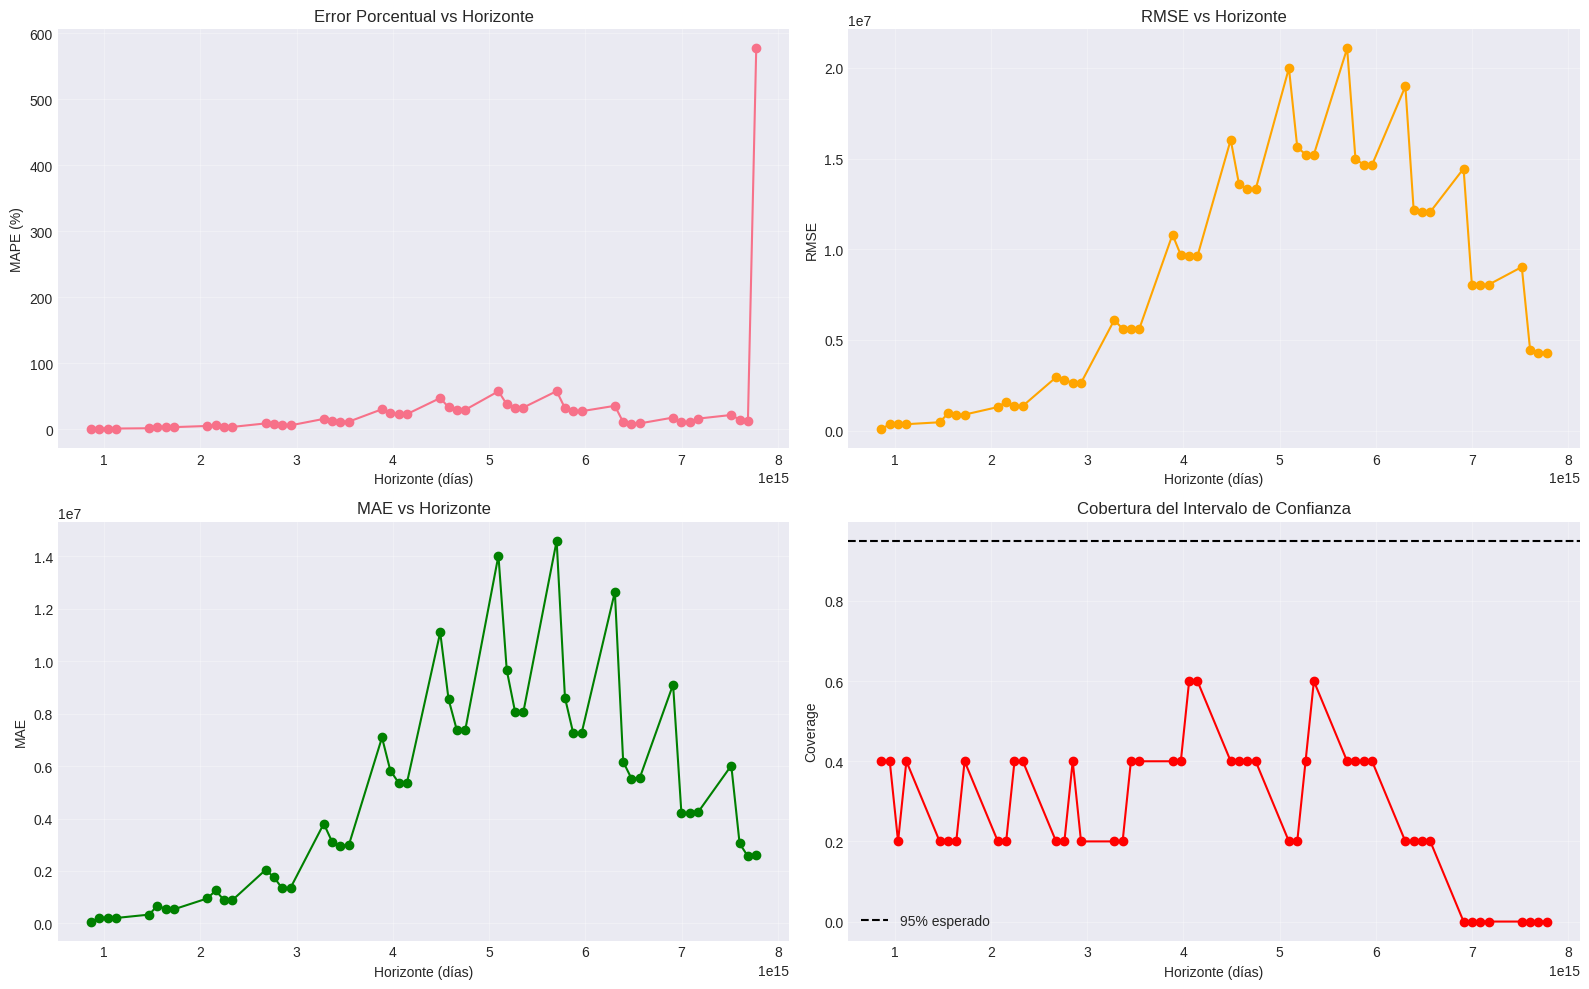


✓ Métricas de validación cruzada visualizadas


In [20]:
# Realizar validación cruzada
# Esto puede tomar varios minutos
print("Realizando validación cruzada (esto puede tomar unos minutos)...")

df_cv = cross_validation(
    model_full,
    initial='365 days',    # Periodo inicial de entrenamiento
    period='90 days',      # Frecuencia de validación
    horizon='90 days'      # Horizonte de predicción
)

print("✓ Validación cruzada completada")

# Calcular métricas de performance
df_performance = performance_metrics(df_cv)

print("\nMétricas de validación cruzada:")
display(df_performance.head())

# Visualizar métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(df_performance['horizon'], df_performance['mape'], 'o-')
axes[0, 0].set_xlabel('Horizonte (días)')
axes[0, 0].set_ylabel('MAPE (%)')
axes[0, 0].set_title('Error Porcentual vs Horizonte')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_performance['horizon'], df_performance['rmse'], 'o-', color='orange')
axes[0, 1].set_xlabel('Horizonte (días)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE vs Horizonte')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_performance['horizon'], df_performance['mae'], 'o-', color='green')
axes[1, 0].set_xlabel('Horizonte (días)')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE vs Horizonte')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df_performance['horizon'], df_performance['coverage'], 'o-', color='red')
axes[1, 1].set_xlabel('Horizonte (días)')
axes[1, 1].set_ylabel('Coverage')
axes[1, 1].set_title('Cobertura del Intervalo de Confianza')
axes[1, 1].axhline(y=0.95, color='black', linestyle='--', label='95% esperado')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Métricas de validación cruzada visualizadas")

## 13. Resumen Ejecutivo y Recomendaciones

In [21]:
print("=" * 70)
print("RESUMEN EJECUTIVO - MODELO DE PREDICCIÓN DE DEMANDA")
print("=" * 70)

print(f"\n📊 DATOS UTILIZADOS")
print(f"  • Periodo: {df_pd['ds'].min().strftime('%Y-%m-%d')} a {df_pd['ds'].max().strftime('%Y-%m-%d')}")
print(f"  • Total de semanas: {len(df_pd)}")
print(f"  • Granularidad: Semanal")
print(f"  • Variable objetivo: payment_value (ventas totales)")

print(f"\n🤖 MODELO")
print(f"  • Algoritmo: Prophet (Meta/Facebook)")
print(f"  • Estacionalidad: Multiplicativa")
print(f"  • Componentes: Tendencia + Anual + Semanal + Holidays BR")

print(f"\n📈 PERFORMANCE EN TEST SET")
print(f"  • MAPE: {mape:.2f}%")
print(f"  • MAE: R$ {mae:,.2f}")
print(f"  • RMSE: R$ {rmse:,.2f}")
print(f"  • R²: {r2:.4f}")

print(f"\n🎯 PRONÓSTICO PRÓXIMO TRIMESTRE")
print(f"  • Periodo: {forecast_future['Fecha'].min().strftime('%Y-%m-%d')} a {forecast_future['Fecha'].max().strftime('%Y-%m-%d')}")
print(f"  • Ventas esperadas: R$ {total_predicho:,.2f}")
print(f"  • Escenario pesimista: R$ {total_inferior:,.2f}")
print(f"  • Escenario optimista: R$ {total_superior:,.2f}")
print(f"  • Crecimiento vs trimestre anterior: {growth_pct:+.2f}%")

print(f"\n💡 INSIGHTS CLAVE")
# Identificar mes con mayores ventas en el pronóstico
forecast_future_copy = forecast_future.copy()
forecast_future_copy['Mes'] = pd.to_datetime(forecast_future_copy['Fecha']).dt.month
best_month = forecast_future_copy.groupby('Mes')['Predicción'].sum().idxmax()
month_names = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
               7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

print(f"  • Mes con mayores ventas proyectadas: {month_names.get(best_month, best_month)}")
print(f"  • Tendencia general: {'Crecimiento' if growth_pct > 0 else 'Decrecimiento'}")

print(f"\n📦 RECOMENDACIONES PARA INVENTARIO")
weekly_avg_forecast = total_predicho / 13
print(f"  1. Preparar inventario para ~R$ {weekly_avg_forecast:,.2f} en ventas semanales")
print(f"  2. Considerar escenario optimista (+{((total_superior-total_predicho)/total_predicho*100):.1f}%) para productos de alta rotación")
print(f"  3. Mantener buffer de seguridad para variaciones estacionales")
print(f"  4. Priorizar stock en {month_names.get(best_month, best_month)} (mes de mayor demanda proyectada)")

print("\n" + "=" * 70)
print("✓ Análisis de predicción de demanda completado")
print("=" * 70)

RESUMEN EJECUTIVO - MODELO DE PREDICCIÓN DE DEMANDA

📊 DATOS UTILIZADOS
  • Periodo: 2016-08-29 a 2018-09-03
  • Total de semanas: 94
  • Granularidad: Semanal
  • Variable objetivo: payment_value (ventas totales)

🤖 MODELO
  • Algoritmo: Prophet (Meta/Facebook)
  • Estacionalidad: Multiplicativa
  • Componentes: Tendencia + Anual + Semanal + Holidays BR

📈 PERFORMANCE EN TEST SET
  • MAPE: 21925.75%
  • MAE: R$ 127,721.39
  • RMSE: R$ 196,947.52
  • R²: -1.3896

🎯 PRONÓSTICO PRÓXIMO TRIMESTRE
  • Periodo: 2018-09-09 a 2018-12-02
  • Ventas esperadas: R$ 8,252,523.54
  • Escenario pesimista: R$ 6,987,354.55
  • Escenario optimista: R$ 9,531,681.49
  • Crecimiento vs trimestre anterior: +140.55%

💡 INSIGHTS CLAVE
  • Mes con mayores ventas proyectadas: Noviembre
  • Tendencia general: Crecimiento

📦 RECOMENDACIONES PARA INVENTARIO
  1. Preparar inventario para ~R$ 634,809.50 en ventas semanales
  2. Considerar escenario optimista (+15.5%) para productos de alta rotación
  3. Mantener bu

## 14. Exportar Resultados

In [22]:
# Guardar pronóstico en CSV
forecast_future.to_csv('Data/pronostico_trimestral.csv', index=False)
print("✓ Pronóstico guardado en: Data/pronostico_trimestral.csv")

# Guardar métricas
metrics_summary = pd.DataFrame({
    'Métrica': ['MAPE (%)', 'MAE (R$)', 'RMSE (R$)', 'R²', 'Ventas Proyectadas Trimestre', 'Crecimiento (%)'],
    'Valor': [mape, mae, rmse, r2, total_predicho, growth_pct]
})
metrics_summary.to_csv('Data/metricas_modelo_demanda.csv', index=False)
print("✓ Métricas guardadas en: Data/metricas_modelo_demanda.csv")

print("\n✓ Todos los resultados exportados exitosamente")

✓ Pronóstico guardado en: Data/pronostico_trimestral.csv
✓ Métricas guardadas en: Data/metricas_modelo_demanda.csv

✓ Todos los resultados exportados exitosamente
